# ML for Time Series

## A Unified Framework for Structured Graph Learning via Spectral Constraints

Baptiste Collet - Cyril Miras

## Experiments

### Setup

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets as skd
import sklearn.metrics as skm
from learnGraphTopology import *

## Denoising a multi-component graph

In [237]:
n_class_feats = 5
n_classes = 4
n_feats = n_classes * n_class_feats
prob_intra = 1
prob_extra = 0.3
max_weight_intra = 1
max_weight_extra = 0.3

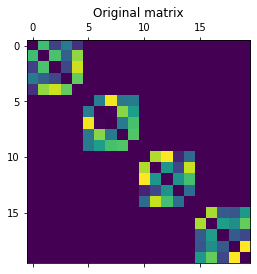

In [256]:
adj = np.zeros((n_feats, n_feats))
for i in range(n_classes):
    i_start = i * n_class_feats
    i_end = i_start + n_class_feats
    for ii in range(i_start, i_end):
        for jj in range(ii+1, i_end):
            adj[ii, jj] = np.random.binomial(n=1, p=prob_intra) * np.random.uniform(high=max_weight_intra)
plt.matshow(adj+adj.T)
plt.title("Original matrix")
plt.show()

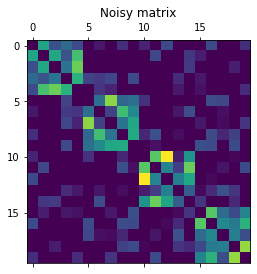

In [257]:
for i in range(n_feats):
    for j in range(i+1, n_feats):
        adj[i, j] += np.random.binomial(n=1, p=prob_extra) * np.random.uniform(high=max_weight_extra)
adj = adj + adj.T
plt.matshow(adj)
plt.title("Noisy matrix")
plt.show()

In [272]:
n_samples = 5 * n_feats
# compute the laplacian and correlation matrices
lap = np.diag(adj.sum(axis=0)) - adj
theta = np.linalg.pinv(lap)
# generate samples
x = np.random.multivariate_normal(np.zeros(n_feats), theta, size=n_samples).T

In [273]:
# learn the laplacian and adjacency matrices
res_denoising = learn_k_component_graph(x, k=4, maxiter=10000)
if res_denoising['convergence']: print("The optimization converged!")

 72%|██████████████████████████████████████████████████████▊                     | 7215/10000 [00:09<00:03, 775.17it/s]

The optimization converged!


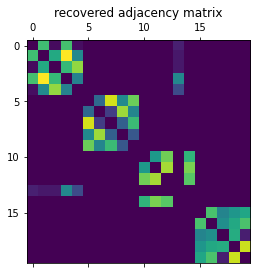

relative error:  0.7448109135163131
naive relative error:  0.6828634954680337


In [274]:
plt.matshow(res_denoising["Adjacency"])
plt.title("recovered adjacency matrix")
plt.show()
print('relative error: ', np.linalg.norm(res_denoising["Laplacian"] - lap)/np.linalg.norm(lap))
print('naive relative error: ', np.linalg.norm(np.linalg.pinv(np.cov(x)) - lap)/np.linalg.norm(lap))

## Popular synthetic datasets

In [121]:
def dist_mat_exp_kernel(x, sigma=1, eps=1, k=None):
    n, d = x.shape
    dist_mat = np.zeros((n, n))
    for i in range(n):
        dist_mat[i] = np.exp(-np.linalg.norm(x[i] - x, axis=1)/eps)
    if not k is None:
        for i in range(n):
            k_th_nearest_dist = np.sort(dist_mat[i])[-k]
            dist_mat[i][dist_mat[i] < k_th_nearest_dist] = 0
        dist_mat = 0.5*(dist_mat + dist_mat.T)
    else:
        dist_mat[dist_mat<eps] = 0
    return dist_mat

We load the "two moons" dataset

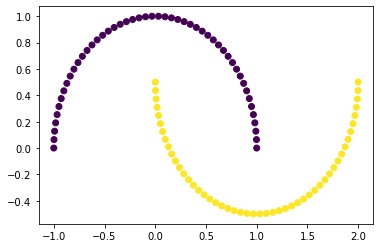

In [122]:
n_samples = 100
moons_data, moons_labels = skd.make_moons(n_samples=n_samples)
plt.scatter(moons_data.T[0], moons_data.T[1], c=moons_labels)
plt.show()

In [123]:
C_moons = dist_mat_exp_kernel(moons_data, sigma=1, eps=0.1)

In [124]:
res_moons = learn_k_component_graph(C_moons, k=2, maxiter=2000) #2000 or more in reality

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:20<00:00, 97.82it/s]


In [125]:
score_moons = np.linalg.eigh(res_moons["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(moons_labels, score_moons))

AUC score of the spectral classifier 1.0


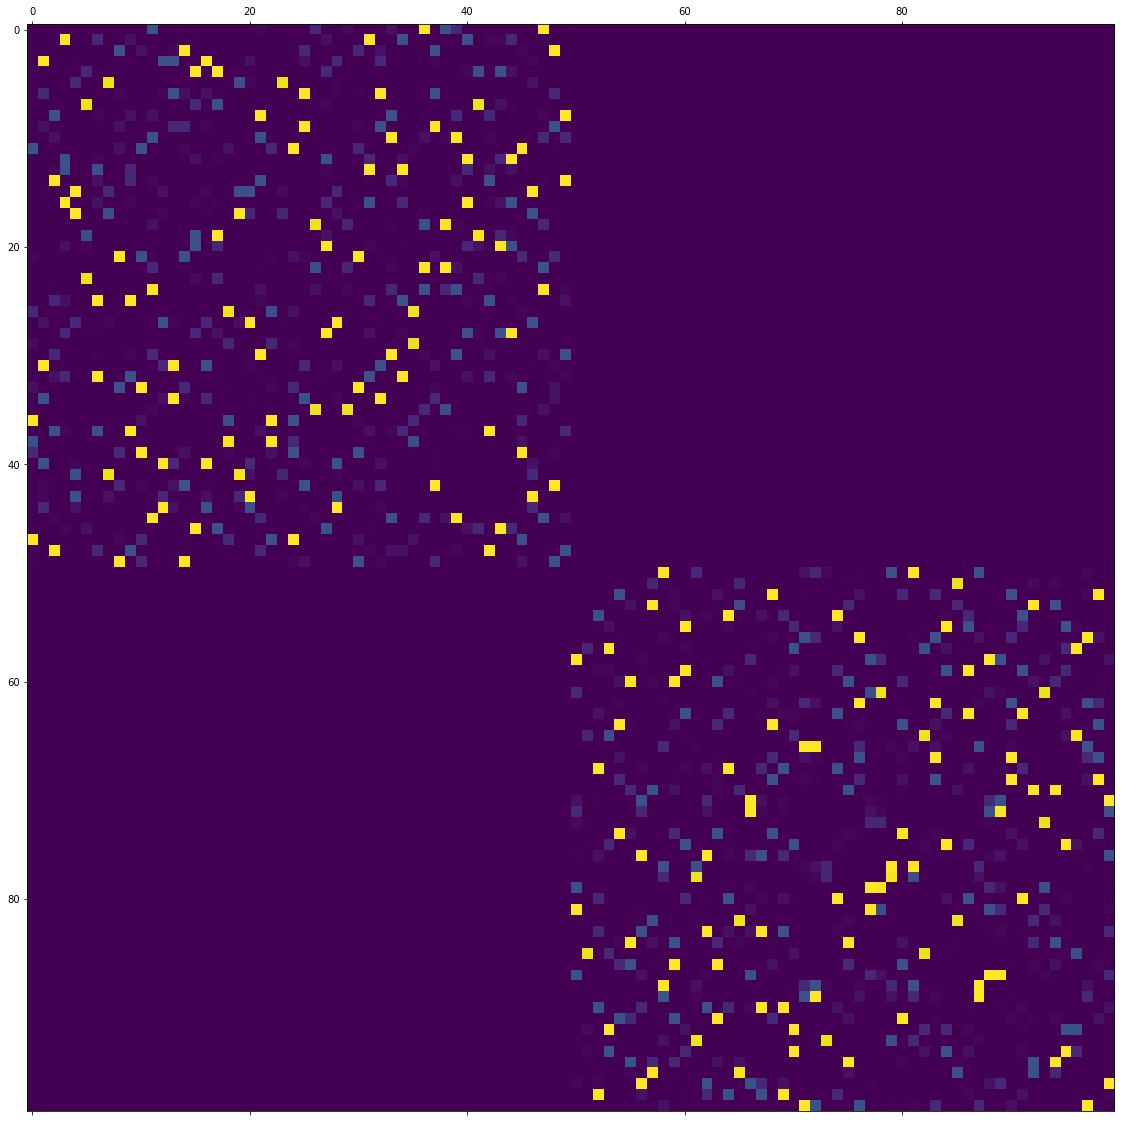

In [126]:
id_moons = np.argsort(moons_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_moons["Adjacency"][id_moons][:, id_moons], fignum=0)
plt.show()

We load the "two circles" dataset

In [127]:
def at_least_k_component(L,k):
    la,M=np.linalg.eigh(L)
    la[:k] = 0
    return M@np.diag(la)@M.T

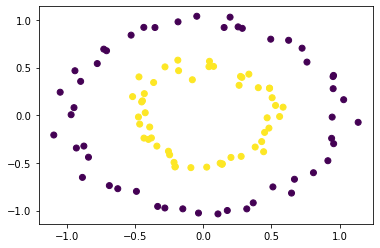

In [128]:
n_samples = 100
circles_data, circles_labels = skd.make_circles(n_samples=n_samples,noise=0.05,factor=0.5)
plt.scatter(circles_data.T[0], circles_data.T[1], c=circles_labels)
plt.show()

In [129]:
C_circles = dist_mat_exp_kernel(circles_data, k=7,sigma=0.1)
res_circles = learn_k_component_graph(C_circles, k=2, maxiter=10000) #2000 or more in reality

 19%|██████████████▌                                                              | 1886/10000 [00:20<01:28, 91.70it/s]


In [130]:
print(res_circles["convergence"])

True


In [131]:
#res_circles["Laplacian"]=at_least_k_component(res_circles["Laplacian"],k=2)

In [132]:
print(nb_connected_component(res_circles["Laplacian"]))

1


In [133]:
print(np.array([[0.3,0.02],[0.02,0.3]]).round(1))
np.linalg.eigh(res_circles["Laplacian"])[0][1]

[[0.3 0. ]
 [0.  0.3]]


8.502951702882746e-07

In [134]:
score_circles = np.linalg.eigh(res_circles["Laplacian"])[1][:, 1]
print("AUC score of the spectral classifier", skm.roc_auc_score(circles_labels, score_circles))

AUC score of the spectral classifier 0.4884


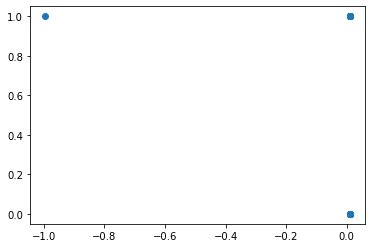

In [135]:
plt.scatter(score_circles, circles_labels)

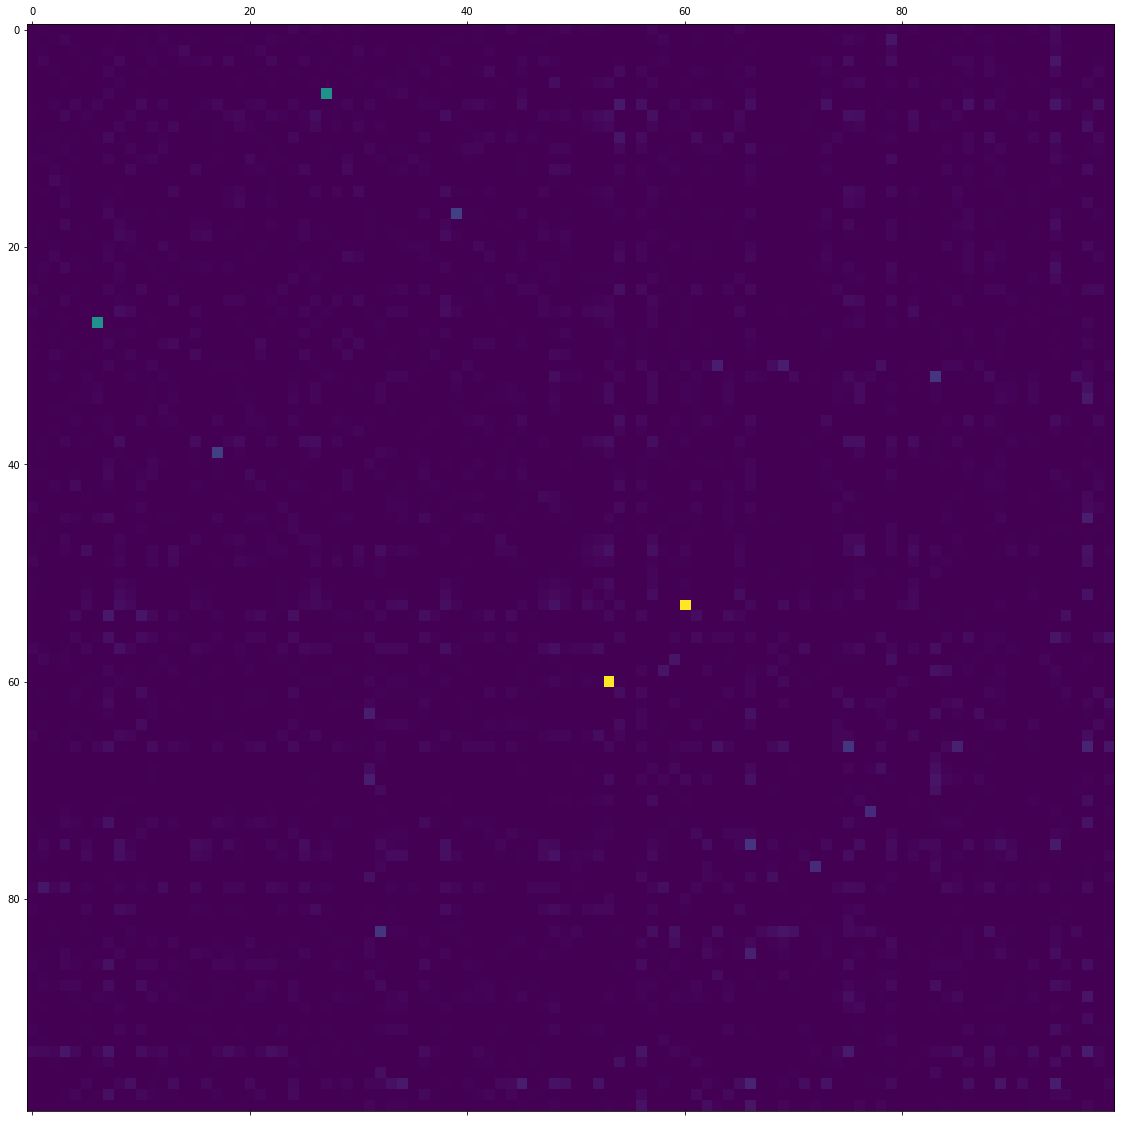

In [136]:
id_circles = np.argsort(circles_labels)
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_circles["Adjacency"][id_circles][:, id_circles], fignum=0)
plt.show()

In [137]:
A=res_circles["Adjacency"][id_circles][:, id_circles]
print(np.max(A[60:,:40]),np.max(A[:40,60:]))
print(np.max(A))

11.482179668074943 11.482179668074943
77.27946943541146


In [138]:
def helix_3D(n_samples, h=20, angle=np.pi/2):
    labels=np.array([0]*(n_samples//2)+[1]*((n_samples+1)//2))
    np.random.shuffle(labels)
    ha = np.random.rand(n_samples)*h
    return np.array([[np.cos(a+b),np.sin(a+b),a] for a,b in zip(ha,labels)]),labels

In [139]:
def three_circles(n_samples,factor=0.5):
    labels=np.zeros([n_samples])
    labels[-n_samples//3:]=2
    labels[n_samples//3:-n_samples//3]=1
    np.random.shuffle(labels)
    angles= np.random.rand(n_samples)*2*np.pi
    print(angles,labels)
    return np.array([[np.cos(a)*factor**b,np.sin(a)*factor**b] for a,b in zip(angles,labels)]),labels

In [140]:
print(three_circles(6))

[5.20253152 0.87298452 5.20277821 1.39174284 2.67058582 3.23010984] [0. 1. 2. 1. 0. 2.]
(array([[ 0.47075165, -0.88226577],
       [ 0.32127126,  0.38312501],
       [ 0.11774232, -0.2205374 ],
       [ 0.08904913,  0.49200635],
       [-0.89111185,  0.45378372],
       [-0.24902123, -0.02210041]]), array([0., 1., 2., 1., 0., 2.]))


## Gene dataset

This dataset come from https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#

It represents 801 patients with cancers of 5 different types

The features of the data are RNA-Seq gene expression levels

The label is the tumor type

To make the code work, download the dataset,extract it and save data and labels in the folder ./data/genes/

In [141]:
gene_df = pd.read_csv("data/genes/data.csv")
gene_df = gene_df[gene_df.columns[1:]]
gene_df

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.000000
1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.000000
2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.000000
3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.000000
4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.0,1.865642,2.718197,7.350099,10.006003,0.0,6.764792,0.496922,0.0,0.0,...,6.088133,9.118313,10.004852,4.484415,9.614701,12.031267,9.813063,10.092770,8.819269,0.000000
797,0.0,3.942955,4.453807,6.346597,10.056868,0.0,7.320331,0.000000,0.0,0.0,...,6.371876,9.623335,9.823921,6.555327,9.064002,11.633422,10.317266,8.745983,9.659081,0.000000
798,0.0,3.249582,3.707492,8.185901,9.504082,0.0,7.536589,1.811101,0.0,0.0,...,5.719386,8.610704,10.485517,3.589763,9.350636,12.180944,10.681194,9.466711,4.677458,0.586693
799,0.0,2.590339,2.787976,7.318624,9.987136,0.0,9.213464,0.000000,0.0,0.0,...,5.785237,8.605387,11.004677,4.745888,9.626383,11.198279,10.335513,10.400581,5.718751,0.000000


In [142]:
gene_labels = pd.read_csv("data/genes/labels.csv")
gene_labels = gene_labels[gene_labels.columns[1:]]
gene_labels

,Class
0,PRAD
1,LUAD
2,PRAD
3,PRAD
4,BRCA
...,...
796,BRCA
797,LUAD
798,COAD
799,PRAD


The goal is to model the distribution with a $k$ component graph, in order to clusetr the data into $k$ classes. As there are $k=5$ classes in reality, we try the algorithm with this value.

In [143]:
C = np.cov(gene_df.values)

In [145]:
res_genes = learn_k_component_graph(C, k=5, maxiter=100) #2000 or more in reality

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


Then, we reorganise the matrix according to their labels to see visually if the components that should be connected are effectively connected.

In [146]:
id_genes = np.argsort(gene_labels.values.squeeze())

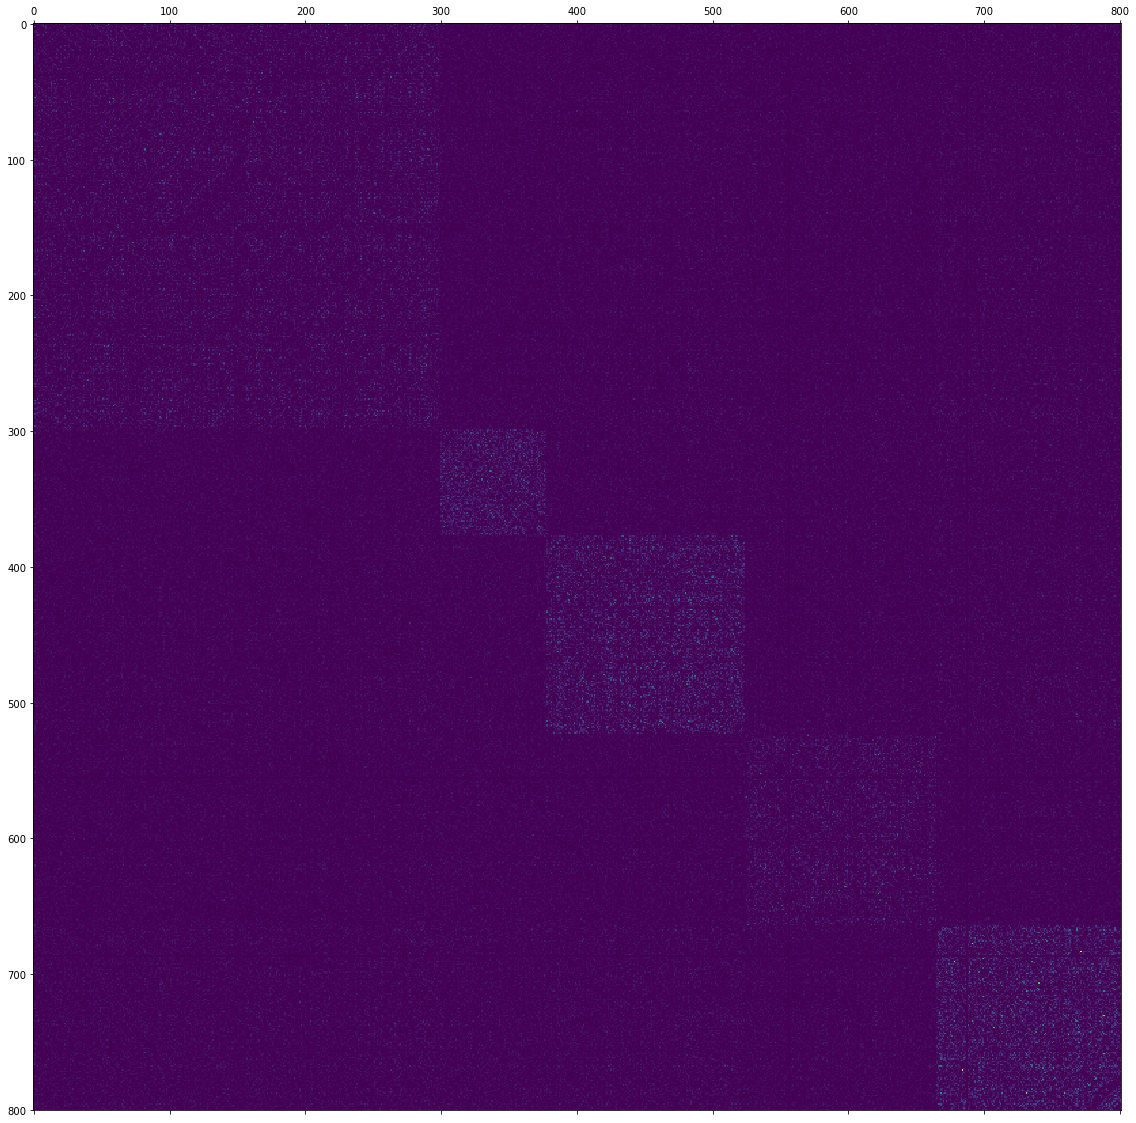

In [147]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(res_genes["Adjacency"][id_genes][:, id_genes], fignum=0)
plt.show()

In [148]:
print(np.sort(np.linalg.eigh(res_genes["Laplacian"])[0]))

[-1.53285483e-14  2.31718352e-01  2.45436949e-01  3.12137544e-01
  5.30304693e-01  8.40623669e+00  8.58032926e+00  8.69718924e+00
  9.21210699e+00  9.30826392e+00  9.32724020e+00  9.40464052e+00
  9.49018003e+00  9.50398160e+00  9.54723649e+00  9.62056740e+00
  9.63966018e+00  9.77453593e+00  9.83226570e+00  9.83873083e+00
  9.85651470e+00  9.92300125e+00  9.95797937e+00  1.00119368e+01
  1.01010572e+01  1.02384375e+01  1.03888836e+01  1.04166007e+01
  1.04672845e+01  1.04920792e+01  1.05840902e+01  1.06984083e+01
  1.07698942e+01  1.07937267e+01  1.08114824e+01  1.08515948e+01
  1.09402272e+01  1.09926624e+01  1.10277455e+01  1.10422568e+01
  1.10871522e+01  1.10912008e+01  1.11352164e+01  1.11740670e+01
  1.12230499e+01  1.12586690e+01  1.12798716e+01  1.13095533e+01
  1.13701124e+01  1.13909578e+01  1.14052108e+01  1.14650423e+01
  1.15100047e+01  1.15392425e+01  1.15710657e+01  1.15960756e+01
  1.16295851e+01  1.16396880e+01  1.16720999e+01  1.16812978e+01
  1.17024837e+01  1.17105

# keyword dataset

In [149]:
act_df = pd.read_csv('data/keyword_activity/ALL.csv', skiprows=9, sep=';')

In [150]:
print(act_df)

       # activity_0   activity_1   activity_2   activity_3   activity_4  \
0            1002.0        925.0       1105.0        973.0        889.0   
1             805.0        805.0       1143.0       1121.0        954.0   
2             542.0        473.0        504.0        626.0        647.0   
3            1406.0        947.0        363.0        180.0         92.0   
4             100.0        184.0         79.0        162.0         99.0   
...             ...          ...          ...          ...          ...   
76342         772.0        359.0        884.0        529.0        838.0   
76343         819.0        708.0        753.0        845.0        780.0   
76344         538.0        600.0        603.0        583.0        660.0   
76345         582.0        743.0       1002.0       1031.0        981.0   
76346         863.0        983.0        900.0       1168.0          0.0   

        activity_5   activity_6   number_of_users_0   number_of_users_1  \
0            939.0      

# sensor displacement

data available at https://archive.ics.uci.edu/ml/machine-learning-databases/00305/

In [153]:
from os import listdir
location = "data/realistic_sensor_displacement"
for filename in listdir(location)[:1]:
    file=(pd.read_csv(location+'/'+filename, skiprows=0, sep='\s+'))

In [154]:
l=file.values

print(l.shape)

(208477, 120)


In [155]:
l=l[:,2:-1]

In [166]:
di=learn_k_component_graph(l.T,k=5,maxiter=1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 80.96it/s]


In [167]:
V=np.linalg.eigh(di["Laplacian"])[1]

In [168]:
ordre=np.argsort(V.T[1,:])
print(ordre.shape)
print(ordre)

(117,)
[  0  52  51  22  79  12  35 103  77  24 116  64  87  90  37  11  93  80
 100  61  66   2  54  14  89   1  15 102   9  76  28  36  41  32  19  74
  92   5 105  45  18  71 110  59 115  46  27  84  97 113  10  48  33  23
  25 112  73   8  57  44  55  16  43  31 108  42  95  82  29  83 109  30
  69  56  96   3  21 107  81  17  68  70  94   4  88  34 101  50  58  63
  62  75  49 114  38   6  85  47 111  98  72  67   7  60  20  86  99 106
  40  53  39  13  26  65 104  91  78]


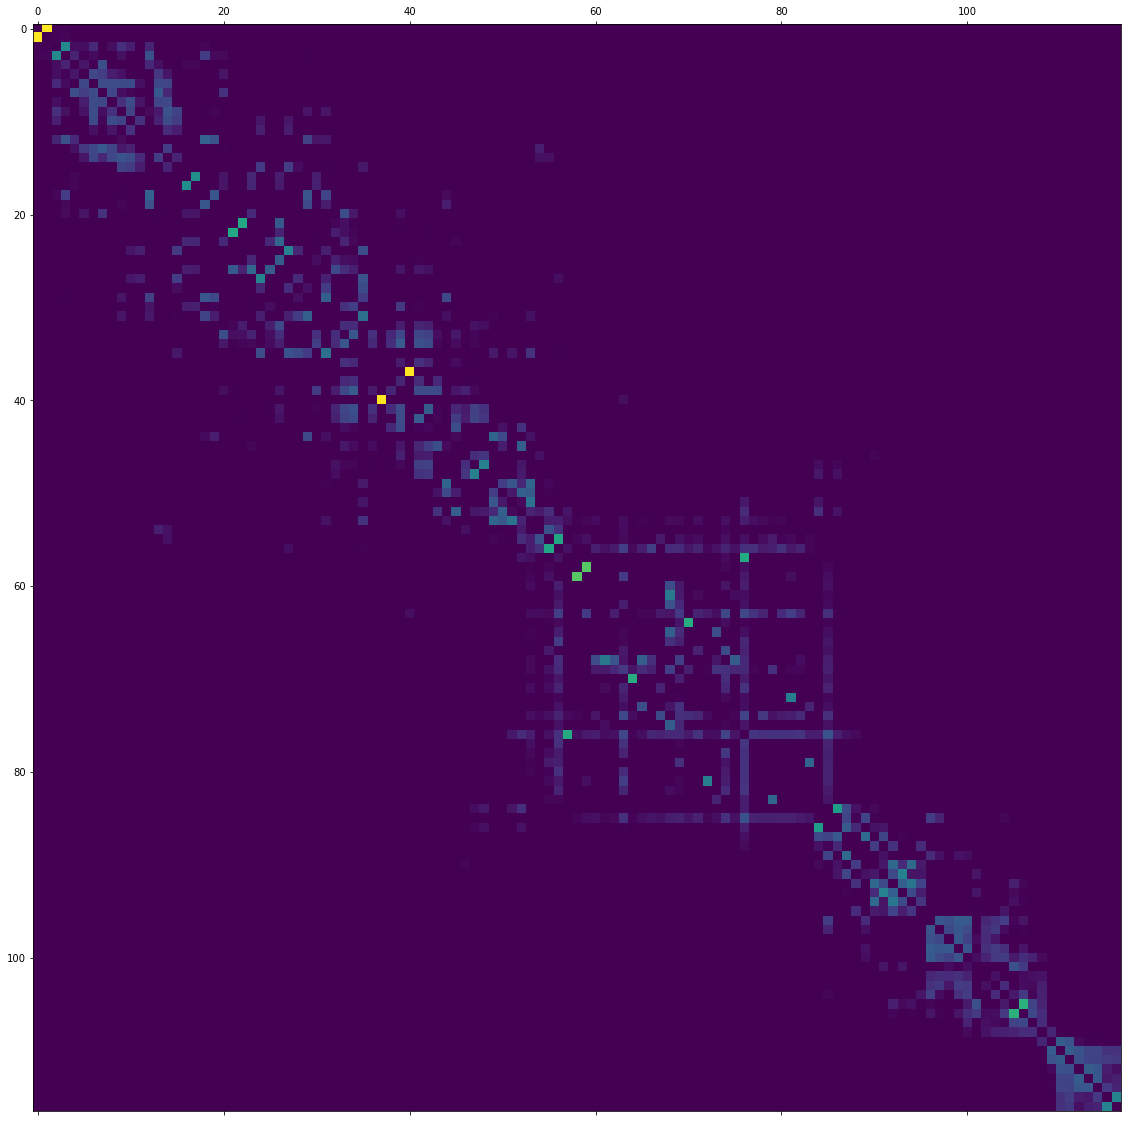

In [169]:
fig = plt.figure(figsize=(20, 20))
plt.matshow(di["Adjacency"][ordre][:,ordre], fignum=0)
plt.show()

In [170]:
print(di["convergence"])

False


In [171]:
print(np.sort(np.linalg.eigh(di["Laplacian"])[0])[:10])

[-1.99140023e-17  7.19441936e-03  1.47883016e-02  1.72820150e-02
  2.48847420e-02  4.07676981e-02  5.04537015e-02  9.73172694e-02
  1.58505807e-01  1.74132604e-01]


In [172]:
print(np.max(di["Laplacian"]))

3.3411801723713066


In [173]:
def A_to_L(A):
    D=np.diag(np.sum(A,axis=0))
    return D-A

In [174]:
A=(di["Adjacency"])*(abs(di["Adjacency"])>10**-3)

In [175]:
L=A_to_L(A)

In [176]:
print(np.sort(np.linalg.eigh(L)[0])[:10])

[-6.86334169e-16  7.18240137e-03  1.47880355e-02  1.72797103e-02
  2.48739809e-02  4.07514418e-02  5.04470107e-02  9.72309643e-02
  1.58438741e-01  1.74044009e-01]
